In [1]:
import Pkg
Pkg.activate("../../Tasks2D")
using Revise, Plots

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [2]:
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

In [3]:
### Construct Environment ###
includet("09/model.jl") # Loads variables: uniform_agent_pos, motion_model, sensor_model

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#332", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#333", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#334", Bool[0, 0], false), var"#13#14"())

In [4]:
# Particle filter for the model above.
includet("09/pf.jl")          # Loads: @get_pf

# A* navigation, using conversion to discrete coordinates.
includet("09/astar_nav.jl")   # Loads: line_to_grid, taxi_dist, find_action_using_grid_search

# Wall following behavior.
includet("09/wall_follow.jl") # Loads: initial_wall_follow_state, wall_follow

# Rule for whether a belief state is sufficiently uncertain to be worth disambiguating.
includet("09/uncertainty_thresholding.jl") # Loads: there_is_ambiguity

In [5]:
# Visualizations.
includet("09/visualize.jl") # Loads: trace_to_gif, trace_to_path_image

In [6]:
# Load the map (line segments, bounding box)
(_segs, _bb, _) = L.load_env_sparse("../../data/environments/ambig.json");

In [7]:
# Parameters for the grid discretization used for planning
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

In [8]:
### Ground truth world model parameters ###
PARAMS = (;
    map = _segs, orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; Δ = 0.25, σ = 0.005 ),
    obs = (; fov = 2π, n_rays = 40,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

In [48]:
### Particle Filter args ###
_grid_args = (;
    tau = 1., pmin = 1e-6, n_iters = 5,
    init_grid_args = (; k = [9, 9], r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3]),
)
_t0_grid_args = (;
    _grid_args..., tau=1., n_iters=6,
    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[7, 13], r=[.8, .8]), initial_pos = [2.7, 6.]
)

INFERENCE_PARAMS = (;
    PARAMS...,
    step = (; Δ = 0.25, σ = 0.1),
    obs = (; PARAMS.obs..., sensor_args=(;
        PARAMS.obs.sensor_args...,
        s_noise = 0.02,
    ))
)

_resampling_args = (; n_particles=40, n_groups=10, ess_threshold=1+1e-4);

### Particle filter ###
pf = @get_pf(INFERENCE_PARAMS, _grid_args, _t0_grid_args, _resampling_args);

In [49]:
(pf_init, pf_update) = pf;

In [50]:
GOAL = [1., 4.];

In [66]:
initial_controller_state =
    (nothing, initial_wall_follow_state(), nothing)

@gen function controller(st, obs)
    # Unpack controller state
    pf_state, wall_following_internal_state, prev_action = st
    
    # Update belief state
    if isnothing(prev_action) # First timestep
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        pf_state = pf_update(pf_state, prev_action, choicemap((:obs, obs)))
    end
    
    # Choose action
    particle = GenParticleFilters.sample_unweighted_traces(pf_state, 1)[1]
    pos = currentpos(particle)
    if there_is_ambiguity(pf_state)
        (action, next_wf_state) = wall_follow(wall_following_internal_state, pos)
    else
        action = find_action_using_grid_search(pos, GOAL)[1]
        # Reset the wall following policy
        next_wf_state = initial_wall_follow_state()
    end
    
    # Return action and new controller state
    return (action, (pf_state, next_wf_state, action))
end

controller = GenPOMDPs.Controller(controller, initial_controller_state)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##controller#1555", Bool[0, 0], false), (nothing, Any[nothing], nothing))

In [67]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1624"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_yRMJMFIrsf.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_yRMJMFIrsf.gif")
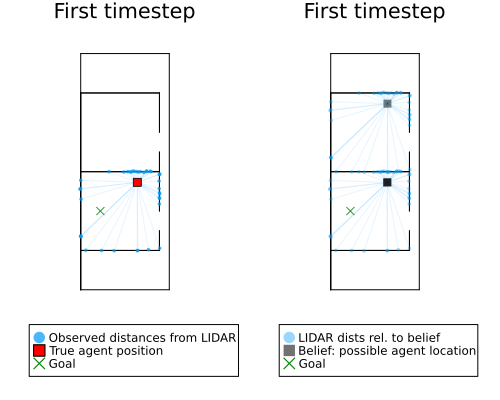

In [80]:
# Simulate rollout to the end of T=0 (ie. generate initial state + obs, and an initial action)
rollout_tr = Gen.simulate(rollout_model, (0, PARAMS))

trace_to_gif(rollout_tr; goal=GOAL, title="First timestep")

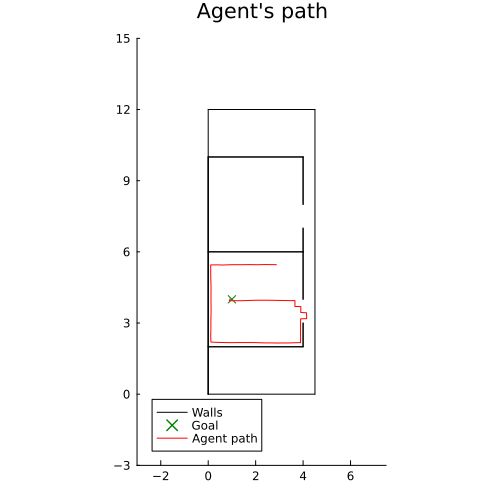

In [82]:
# Extend rollout to 40 steps...
rollout_tr, _ = Gen.update(rollout_tr, (100, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())

trace_to_path_image(rollout_tr; goal=GOAL)

┌ Info: Saved animation to /tmp/jl_cdABCTC3wR.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_cdABCTC3wR.gif")
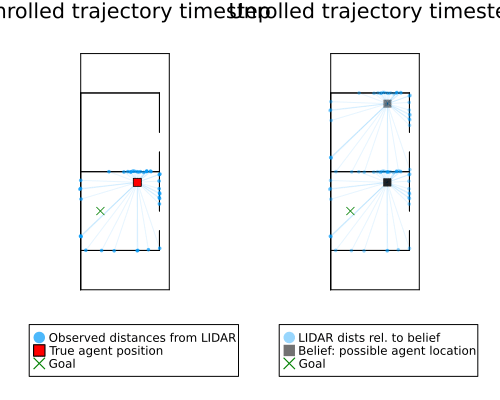

In [83]:
trace_to_gif(rollout_tr; goal=GOAL, fps=10)